In [ ]:
!pip install langdetect
!pip install colorama
!pip install transformers

     |████████████████████████████████| 983kB 8.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=e5e1e714fd40a2fd23cbfd6d53a16522c4cf54dc87ab82e9eab89668abc7e436
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████████████████| 1.9MB 8.1MB/s 
     |████████████████████████████████| 3.2MB 15.8MB/s 
     |████████████████████████████████| 890kB 26.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=172fd91f3300f30c20a365e296987a246d056701dda1600ab26193025dc7188c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/Tesi_alfonsi.ipynb /content/

In [ ]:
!jupyter nbconvert --to latex Tesi_alfonsi.ipynb

[NbConvertApp] Converting notebook Tesi_alfonsi.ipynb to latex
[NbConvertApp] Support files will be in Tesi_alfonsi_files/
[NbConvertApp] Making directory Tesi_alfonsi_files
[NbConvertApp] Writing 478097 bytes to Tesi_alfonsi.tex


In [ ]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import glob 
from tqdm.notebook import tqdm 
import json 
from langdetect import detect
from langdetect import DetectorFactory
import matplotlib.pyplot as plt
import nltk
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import colorama
import re
from transformers import BertForQuestionAnswering, BertTokenizer
import torch
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Progetto

### Fase 1: Estrazione dati

Dati presi dal dataset [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

#### Caricamento su colab dei file 

In [ ]:
!wget https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-11-13.tar.gz

--2021-02-19 14:45:56--  https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-11-13.tar.gz
Resolving ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)... 52.218.249.153
Connecting to ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com (ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com)|52.218.249.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5842447433 (5.4G) [binary/octet-stream]
Saving to: ‘cord-19_2020-11-13.tar.gz’

cord-19_2020-11-13. 100%[===================>]   5.44G  22.1MB/s    in 4m 23s  

2021-02-19 14:50:20 (21.2 MB/s) - ‘cord-19_2020-11-13.tar.gz’ saved [5842447433/5842447433]



In [ ]:
!tar xvzf cord-19_2020-11-13.tar.gz

2020-11-13/changelog
2020-11-13/cord_19_embeddings.tar.gz
2020-11-13/document_parses.tar.gz
2020-11-13/metadata.csv


In [ ]:
!tar xvzf ./2020-11-13/document_parses.tar.gz

Output streaming troncato alle ultime 5000 righe.
document_parses/pdf_json/937aeb7679972e8dcc0260db6d625a528cc6c67f.json
document_parses/pdf_json/38c817da536681b5b4d9238b536b735dcee484af.json
document_parses/pdf_json/a7c93aef84cf027c5a743e88ea6def460d217e32.json
document_parses/pdf_json/33dbab43b88aae90d46ee353a53464347076cca3.json
document_parses/pdf_json/f09d415f499bfc4cdc399f605a9637d32c86c6a9.json
document_parses/pmc_json/PMC7170707.xml.json
document_parses/pdf_json/23189ddded3305702637c1f94ede1d4cf36cb755.json
document_parses/pmc_json/PMC7458253.xml.json
document_parses/pmc_json/PMC7508127.xml.json
document_parses/pdf_json/9300fec8bbd77a32ed468de8145a0aa92382031e.json
document_parses/pmc_json/PMC7220163.xml.json
document_parses/pdf_json/4ef667018d10664b5e1f42c329ac3981b67aca4e.json
document_parses/pmc_json/PMC7544400.xml.json
document_parses/pmc_json/PMC7513788.xml.json
document_parses/pdf_json/0fc99e297c56841640c002bada6e2cb8386bafae.json
document_parses/pmc_json/PMC7556263.xml.j

In [ ]:
metadata = pd.read_csv('2020-11-13/metadata.csv') 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346259 entries, 0 to 346258
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          346259 non-null  object 
 1   sha               122134 non-null  object 
 2   source_x          346259 non-null  object 
 3   title             346107 non-null  object 
 4   doi               206094 non-null  object 
 5   pmcid             128841 non-null  object 
 6   pubmed_id         181069 non-null  object 
 7   license           346259 non-null  object 
 8   abstract          247356 non-null  object 
 9   publish_time      345915 non-null  object 
 10  authors           334941 non-null  object 
 11  journal           325236 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  124553 non-null  object 
 14  arxiv_id          4494 non-null    object 
 15  pdf_json_files    122134 non-null  object 
 16  pmc_json_files    94

#### Estrazione articoli e creazione dataframe

In [ ]:
def get_article(article):
    '''preso un articolo, controlla che sia rilevante all'argomento covid
     e poi restituisce il suo id, l'abstract, il body text e il titolo'''
    paper_id=article['paper_id']
    abstract=[]
    body_text=[]
    title=article['metadata']['title']

    relevant=0

    #aggiungo solo gli articoli che sono rilevanti al covid
    covid_list = ["COVID", "covid", "Covid","2019-nCov" ]

    for entry in article['abstract']:
      abstract.append(entry['text'])
    for idx in range(len(article["body_text"])):
      if any(word in article["body_text"][idx]["text"] for word in covid_list): 
        relevant=1
      body_text.append(article["body_text"][idx]["text"])
    if relevant==1:
      abstract = '\n'.join(abstract)
      body_text = '\n'.join(body_text)

      return [paper_id, abstract, body_text, title]
    return 0
    

def load_files(filepath):
    
    '''prende i paper nel percorso specificato  e crea un dataframe con i paper i quali hanno titolo, abstract e full text 
    e che sono rilevanti all'argomento covid-19'''
    
    dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'title': []}

    articles_paths = glob.glob(filepath,recursive = True) #recupero i percorsi degli articoli

    print('\nCaricamento di tutti gli articoli')
    
    for article_path in tqdm(articles_paths):
      full_article = json.load(open(article_path, 'rb'))  
      article=get_article(full_article)
      if article==0 or len(article[1])<10 or len(article[2])<50 or len(article[3])<10:
        continue
      dict_['paper_id'].append(article[0])
      dict_['abstract'].append(article[1])
      dict_['body_text'].append(article[2])
      dict_['title'].append(article[3])

    df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'title'])
    return df_covid

Creo il dataframe con id, abstract, full text e titolo di tutti i paper rilevanti

In [ ]:
df = load_files("document_parses/pdf_json/*.json")


Caricamento di tutti gli articoli


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39688 entries, 0 to 39687
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   39688 non-null  object
 1   abstract   39688 non-null  object
 2   body_text  39688 non-null  object
 3   title      39688 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [ ]:
df.head()

,paper_id,abstract,body_text,title
0,1765d8c729f95d48b4d97581d8f443f45c89455d,The Bacille Calmette-Guérin (BCG) tuberculosis...,The Bacille Calmette-Guérin (BCG) tuberculosis...,BCG vaccination in infancy does not protect ag...
1,1804de6cc2ba364637e1d0af7fa24580d352e6fa,The COVID-19 pandemic has impacted lives globa...,Patients and families often struggle with the ...,Trust and Communication: Responding to Uncerta...
2,d9fc42fa80cbe6883609871bf1b7047203e1294e,Since the first case of and its progression to...,Since the first case of COVID-19 and its progr...,Special feature Oncology practice in the COVID...
3,6f88a3e1b28009498626f6dbd30402dcf45d7bb8,Introduction: Severe acute respiratory syndrom...,Coronavirus disease is caused by the novel vir...,Neurological manifestations of COVID-19: a sys...
4,4b270854ec92349468f017fd353b7dc86523bdaf,The early postpartum period is crucial for mot...,Due to the physiological changes in the immune...,Preeclampsia and the crucial postpartum period...


#### Gestione duplicati

In [ ]:
df['title'].describe(include='all')

count                 39688
unique                38125
top       Journal Pre-proof
freq                     58
Name: title, dtype: object

Rimuovo tutti i duplicati

In [ ]:
df.drop_duplicates(['title'], inplace=True)
df.drop_duplicates(['abstract'], inplace=True)
df.drop_duplicates(['body_text'], inplace=True)
df.drop_duplicates(['paper_id'], inplace=True)
df['paper_id'].describe(include='all')

count                                        37769
unique                                       37769
top       8496881682f8a7aef61fa4aa563d9766c4ee5858
freq                                             1
Name: paper_id, dtype: object

#### Rimozione degli articoli non in inglese

In [ ]:
DetectorFactory.seed = 0
languages = []

# aggiungo nel dataframe una colonna contenente la lingua di ogni paper
for ii in tqdm(range(0,len(df))):
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    
    languages.append(lang)

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Documenti: {}\n".format(len(languages)))
pprint(languages_dict)

Documenti: 37769

{'ca': 3,
 'de': 149,
 'en': 37263,
 'es': 190,
 'fa': 1,
 'fr': 129,
 'hr': 1,
 'id': 2,
 'it': 9,
 'nl': 8,
 'pt': 12,
 'tr': 1,
 'vi': 1}


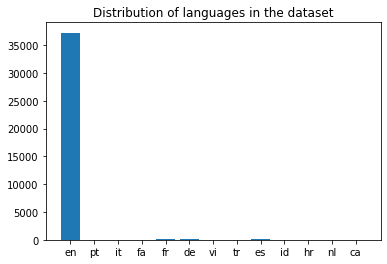

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of languages in the dataset")
plt.show()

In [ ]:
df = df[df['language'] == 'en'] 
df = df.drop(columns=['language'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37263 entries, 0 to 39687
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   37263 non-null  object
 1   abstract   37263 non-null  object
 2   body_text  37263 non-null  object
 3   title      37263 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


### Fase 2: Ricerca documenti più rilevanti rispetto ad una query

In [ ]:
df

,paper_id,abstract,body_text,title
0,1765d8c729f95d48b4d97581d8f443f45c89455d,The Bacille Calmette-Guérin (BCG) tuberculosis...,The Bacille Calmette-Guérin (BCG) tuberculosis...,BCG vaccination in infancy does not protect ag...
1,1804de6cc2ba364637e1d0af7fa24580d352e6fa,The COVID-19 pandemic has impacted lives globa...,Patients and families often struggle with the ...,Trust and Communication: Responding to Uncerta...
2,d9fc42fa80cbe6883609871bf1b7047203e1294e,Since the first case of and its progression to...,Since the first case of COVID-19 and its progr...,Special feature Oncology practice in the COVID...
3,6f88a3e1b28009498626f6dbd30402dcf45d7bb8,Introduction: Severe acute respiratory syndrom...,Coronavirus disease is caused by the novel vir...,Neurological manifestations of COVID-19: a sys...
4,4b270854ec92349468f017fd353b7dc86523bdaf,The early postpartum period is crucial for mot...,Due to the physiological changes in the immune...,Preeclampsia and the crucial postpartum period...
...,...,...,...,...
39683,e143d487cc4c67e657839c502526b746f44ef3fe,Hypoxemia is the main feature of COVID-19-rela...,Hypoxemia is the main feature of COVID-19-rela...,Is hypoxemia explained by intracardiac or intr...
39684,c5db765ae244729213af0a4356139606912cf98d,The restrictions put in place to contain the C...,The COVID-19 pandemic has swept through the gl...,Risk and Protective Factors for Prospective Ch...
39685,ecbf20f20f59b28c7b07f985125fc83d767f3515,Sacubitril/valsartan is a new medication appro...,Sacubitril/valsartan is a new medication for t...,Effect of Sacubitril/Valsartan on Neurocogniti...
39686,4a06a5447ca98fcd8440759402cd3c902a610d3f,"To explore the epidemic mode of COVID-19, we m...","e coronavirus disease 2019 (COVID-19), caused ...",A Silent Infection Pandemic of COVID-19: Epide...


##### Pre-processing

Carico stopwords comuni

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stoplist = nltk.corpus.stopwords.words("english")

Aggiungo alcune parole comuni ai paper scientifici

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stoplist:
        stoplist.append(w)

In [ ]:
stoplist[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Tolgo anche la punteggiatura

In [ ]:
import string

punctuations = string.punctuation

In [ ]:
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Uso scispaCy, che è un package di Python contenente modelli di spaCy per processare testi scientifici.

In [ ]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
import en_core_sci_lg

In [ ]:
nlp = en_core_sci_lg.load(disable=["tagger", "ner"])
nlp.max_length = 3000000

Creo la funzione my_tokenizer, la quale avrà il compito di tokenizare i documenti passati in input, applicando inoltre lemmatizzazione e rimozione di tutte le stopword.

In [ ]:
def my_tokenizer(sentence):
  tokens = nlp(sentence)
  tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
  tokens = [ word for word in tokens if word not in stoplist and word not in punctuations ]
  tokens = " ".join([i for i in tokens])
  return tokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(my_tokenizer)

#### Similarità del coseno

In [ ]:
def cos_sim(X, Q, top):
  dic = {}
  sim_matrix = cosine_similarity(X, Q)
  for ques_idx in range(sim_matrix.shape[1]):
          dic[ques_idx] = []
          top_paper_idx_list = sorted(range(len(sim_matrix[:, ques_idx])), key=lambda i: sim_matrix[:,ques_idx][i], reverse=True)[:top]
          dic[ques_idx] = [(top_idx, sim_matrix[top_idx, ques_idx]) for top_idx in top_paper_idx_list]
  return dic

###Fase 3: Question Answering

####Caricamento del model e del tokenizer per il QA

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

####Caricamento delle domande e vettorizzazione

In [ ]:
df = pd.read_csv("drive/MyDrive/df.csv") 

In [ ]:
questions=['what are the most common symptoms of covid?','Can animals transmit coronavirus?','How does heart disease affect patients?','How is covid transmitted?', 'What is the mean incubation time for covid?']

In [ ]:
text = df['processed_text'].values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text)

In [ ]:
tqdm.pandas()
questions_df=pd.DataFrame(questions)
processed_query=questions_df[0].progress_apply(my_tokenizer)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [ ]:
Q=vectorizer.transform(processed_query)
print('X shape: '+ str(X.shape))
print('Q shape: ' + str(Q.shape))

X shape: (37262, 528054)
Q shape: (5, 528054)


####Ricerca dei documenti più rilevanti per ogni domanda

In [ ]:
dic=cos_sim(X, Q, 5)
df_dic={}
for ques_idx in dic:
    new_df = df.iloc[[item[0] for item in dic[ques_idx]], :]
    new_df['score'] = [item[1] for item in dic[ques_idx]]
    new_df['question'] = questions_df[0][ques_idx]
    df_dic[ques_idx]=new_df.copy()
relevant_docs=df_dic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



####Creazione delle funzioni per il QA

In [ ]:
def extract_answer(question, text):
  # Applica il tokenizer all'input, considerandoli come una coppia
  input_ids = tokenizer.encode(question, text)
  input_ids = input_ids[0:512]
  # Cerca l'input_ids del primo token [SEP]
  sep_index = input_ids.index(tokenizer.sep_token_id)
  # Il numero di token del segmento A include anche [SEP]
  num_seg_a = sep_index + 1
  # Il resto sono del segmento B
  num_seg_b = len(input_ids) - num_seg_a
  # Creo la lista di 0 e 1
  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  # Per ogni token di input dovrebbe esserci un segment_id
  assert len(segment_ids) == len(input_ids)
    
  # Passa al modello gli embeddings
  start_scores, end_scores = model(torch.tensor([input_ids]), # I token dell'input
                              token_type_ids=torch.tensor([segment_ids]), return_dict=False) # I segment ids per distinguere la domanda dal contesto
  
  # Recupera le stringhe dei token
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  # Trova i token con punteggi più alti di 'start' ed 'end'
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)
    
  if answer_start <= 0 or answer_end <= 0 or answer_end <= answer_start:
      answer = "Not Found"
      score = float('-inf')  
  else:
      # Comincia dal primo token
      answer = tokens[answer_start]
      # Seleziona gli answer token rimasti e li unisce
      for i in range(answer_start + 1, answer_end + 1):
        # Se è il token di una parte di una parola la riunisce con i token precedenti
          if tokens[i][0:2] == '##':
              answer += tokens[i][2:]
          # Altrimenti aggiunge uno spazio e poi il token
          else:
              answer += ' ' + tokens[i]

      # Estrae la risposta
      answer = answer.replace('[CLS]', '')
      answer = answer.replace('[SEP]', '').strip()
      # Estrae il punteggio
      score = (start_scores.max() + end_scores.max()) / 2
      score = score.item()
  return answer, score

In [ ]:
# restituisce la risposta con punteggio più alto, il punteggio e il contesto dei 5 documenti più rilevanti
def get_excerpts_and_scores(question, docs):
    excerpts = []
    scores = []
    contexts = []
    for ind, doc in docs.iterrows(): #cicla i documenti
        # trova inizialmente la risposta usando come contesto l'abstract, e il relativo punteggio verrà usato come baseline
        context=doc['abstract']
        excerpt, score = extract_answer(question, context)  
        text=doc['body_text'] # recupera il testo dell'articolo
        token_text = sent_tokenize(text) # lo divide in frasi
        ans, score1 = extract_answer(question, token_text[0]) # usa come contesto la prima frase
        if score1>score: 
          score=score1
          excerpt=ans
          context=token_text[0]
        # cicla tutte le frasi del testo dell'articolo
        for i in tqdm(range(1,len(token_text)-2)):
          sentence=token_text[i]
          if len(token_text[i-1] + sentence)<520:
            sentence=token_text[i-1] + ' ' + sentence
            while len(sentence+token_text[i+1])<520:
              sentence=sentence+' '+token_text[i+1] # raggruppa le frasi in modo stando attento a non superare una soglia che non permetta di usarle come contesto per BERT
              i=i+1
              if i==len(token_text)-1:
                break
          ans, score1 = extract_answer(question, sentence)
          if score1>score: 
            score=score1
            excerpt=ans
            context=sentence
        ans, score1 = extract_answer(question, token_text[len(token_text)-1]) # usa come contesto l'ultima frase
        if score1>score: 
          score=score1
          excerpt=ans
          context=token_text[len(token_text)-1]
          print(str(score) + ' : ' + excerpt)
        excerpts.append(excerpt)
        scores.append(score)
        contexts.append(context)
    return excerpts, scores, contexts

In [ ]:
# per ogni domanda mette in ordine le riposte in base al punteggio e poi richiama la funzione per stampare i risultati
def get_answers(relevant_docs, questions):
  n=5
  i=0
  for q in questions:
    excerpts, scores, contexts = get_excerpts_and_scores(q, relevant_docs[i])
    top_indices = [i[0] for i in sorted(enumerate(scores), key=lambda x:-x[1])][0:n]
    print_top_n_articles(q, n, relevant_docs, scores, excerpts, contexts, top_indices, i)
    i=i+1

In [ ]:
 #stampa i risultati
 def print_top_n_articles(question, n, top_n_articles, scores, excerpts, contexts, top_indices, q):
    print("========  " + question + "  ======== \n")

    for i, top_idx in enumerate(top_indices):
        print("Rank: " + str(i+1))
        data = top_n_articles[q].iloc[top_idx]
        
        print("Answer: " + excerpts[top_idx])
        print("Title of the document: " + data['title'])
        print("Confidence: " + str(scores[top_idx]))
        
        context=contexts[top_idx]
        
        # pulisce la risposta
        excerpt = excerpts[top_idx]
        excerpt = re.sub(' -', '-', excerpt)
        excerpt = re.sub('- ', '-', excerpt)
        excerpt = re.sub(' ,', ',', excerpt)
        excerpt = re.sub(r'\s([?.!"](?:\s|$))', r'\1', excerpt)
        excerpt = re.sub('\( ', '(', excerpt)
        excerpt = re.sub(' \)', ')', excerpt)
        
        # evidenzia la risposta in rosso
        insensitive_excerpt = re.compile(re.escape(excerpt), re.IGNORECASE)
        highlighted_text = insensitive_excerpt.sub('\033[31m' + excerpt + '\033[39m', context)
        print("Context: " + highlighted_text)
        print('\n')

####Esecuzione

In [ ]:
get_answers(relevant_docs, questions)

Token indices sequence length is longer than the specified maximum sequence length for this model (849 > 512). Running this sequence through the model will result in indexing errors


Question: what are the most common symptoms of covid?

Document ID : 23477
Baseline - Puneggio: 5.757956027984619. Risposta : fever 81 . 2 %

Searching for the answer in the full text of the document


Punteggio: 8.278873443603516.
Risposta : fever , cough , and myalgia or fatigue.

Punteggio: 8.529903411865234.
Risposta : fever , cough , and myalgia or fatigue.


Risposta finale del documento: fever , cough , and myalgia or fatigue
-----------------------------------------------------------------
Document ID : 37140
Baseline - Puneggio: -2.7167749404907227. Risposta : coronavirus 2 ( sars - cov - 2 ) , caused the current global pandemic

Searching for the answer in the full text of the document


Punteggio: 0.15654103457927704.
Risposta : clinical presentation with a severity profile.

Punteggio: 0.9598311185836792.
Risposta : how the disease spread to cause an epidemic.

Punteggio: 1.2986180782318115.
Risposta : cell entry that infects lung epithelial cells and synergistic entry through endosome proteases cell prime entry that infects the host cell.

Punteggio: 2.3727550506591797.
Risposta : elders are more prone to covid - 19 and were more likely to require invasive mechanical ventilation with a high mortality.

Punteggio: 3.042543888092041.
Risposta : ( 10 ) ( 11 ) ( 12 ) ( 13 ) ( 14 ) ( 15 ) ( 16 ).

Punteggio: 5.942148208618164.
Risposta : sore throat , nasal congestion , nausea , vomiting , and myalgia.

Punteggio: 7.258389472961426.
Risposta : sore throat , nasal congestion , nausea , vomiting , and myalgia.

Punteggio: 7.337184906005859.
Risposta : sore throat , nasal congestion , nausea , vomiting , and myalgia.

Punteggio: 7.526995658874512.
Risposta : normal with no 

Punteggio: 7.176639556884766.
Risposta : order of occurrence and likely first symptoms.

Punteggio: 7.775032043457031.
Risposta : fever , cough , nausea / vomiting , then diarrhea.

Punteggio: 7.872922897338867.
Risposta : fever , cough , nausea / vomiting , then diarrhea.

Punteggio: 7.879478454589844.
Risposta : fever , cough , nausea / vomiting , and diarrhea.

Punteggio: 7.8946428298950195.
Risposta : fever , cough , nausea / vomiting , and diarrhea.


Risposta finale del documento: fever , cough , nausea / vomiting , and diarrhea
-----------------------------------------------------------------
Document ID : 1052
Baseline - Puneggio: 6.589297294616699. Risposta : morbidity and mortality

Searching for the answer in the full text of the document


Punteggio: 7.530257225036621.
Risposta : fever , chills , myalgia , or fatigue.

Punteggio: 7.995840072631836.
Risposta : mild upper respiratory and neurologic.


Risposta finale del documento: mild upper respiratory and neurologic
-----------------------------------------------------------------
Document ID : 6879
Baseline - Puneggio: 4.962315559387207. Risposta : diabetes , hypertension , vascular diseases , obesity

Searching for the answer in the full text of the document


Punteggio: 5.154454231262207.
Risposta : diabetes , hypertension , vascular diseases , obesity.

Punteggio: 5.763455390930176.
Risposta : morbidity and mortality.

Punteggio: 6.764276027679443.
Risposta : morbidity and mortality.

Punteggio: 7.80328369140625.
Risposta : headache and loss of smell.


Risposta finale del documento: headache and loss of smell
-----------------------------------------------------------------
Prediction highlighted in red....
========  what are the most common symptoms of covid?  ======== 

Rank: 1
Answer: fever , cough , and myalgia or fatigue
Title of the document: Determine the most common clinical symptoms in COVID-19 patients: a systematic review and meta-analysis Materials and methods
Confidence: 8.529903411865234
Abstract: ter knowledge about this infectious disease. The current systematic review and meta-analysis were aimed to estimate the prevalence of clinical symptoms of COVID-19 in a systematic review and meta-analysis. Methods. A systematic rev

Punteggio: -2.317516803741455.
Risposta : animals and humans.

Punteggio: -0.7810615301132202.
Risposta : there is also evidence to the contrary.

Punteggio: -0.33120864629745483.
Risposta : over 40 % of united kingdom ( uk ) households are estimated to own at least one companion animal.

Punteggio: 0.3490292429924011.
Risposta : companion animal ownership.

Punteggio: 3.0290164947509766.
Risposta : possibility of getting infected with covid - 19 by the animal.


Risposta finale del documento: possibility of getting infected with covid - 19 by the animal
-----------------------------------------------------------------
Document ID : 34376
Baseline - Puneggio: -inf. Risposta : Not Found

Searching for the answer in the full text of the document


Punteggio: -2.2735557556152344.
Risposta : animal research legislation.

Punteggio: -2.0420801639556885.
Risposta : if animal use is unavoidable , attention must be paid to a long list of known variables which may affect the data collected from them.

Punteggio: -0.4842580556869507.
Risposta : if animal use is unavoidable.

Punteggio: -0.24218052625656128.
Risposta : animals themselves.

Punteggio: 0.6094478368759155.
Risposta : in the case of animal studies , just as in the kitchen , the quality of the result is dependent upon planning and conducting , not reporting.

Punteggio: 0.6923614740371704.
Risposta : if this belief is followed in an animal facility , it will not only put the outcome of a scientific study at risk , but it will also endanger the health and lives of both the animals and personnel who are directly or indirectly involved in the study.

Punteggio: 0.9126579761505127.
Risposta : if this belief is followed in an animal facility , it will not only put the outcome of a

Punteggio: -2.547846794128418.
Risposta : coronavirus ?  they define animal health as " a state of physical and psychological well - being and of productivity including reproduction.

Punteggio: -2.3951261043548584.
Risposta : coronavirus ?  animal welfare science can be characterized as the rigorous use of scientific methods to study the quality of life of animals , including that of companion animals , research animals , wildlife , and those farmed for food . this relatively new science ( which has its inception in the 1960s ) is borne out of ethical concern for animals [ 2 , 13 ] and can inform the choice of practices involving animals.

Punteggio: -2.3713018894195557.
Risposta : coronavirus ?  this relatively new science ( which has its inception in the 1960s ) is borne out of ethical concern for animals [ 2 , 13 ] and can inform the choice of practices involving animals.

Punteggio: -1.6723451614379883.
Risposta : can inform interventions to prevent and treat diseases and vice - v

Punteggio: -1.876035451889038.
Risposta : changes in visitor tastes may be used to improve animal welfare standards in the future.

Punteggio: -1.8702192306518555.
Risposta : animal welfare standards in the future.

Punteggio: -1.2682050466537476.
Risposta : diversification in the sorts of animals commoditised , the destinations offered and array of interactions with animals available.

Punteggio: 2.2920331954956055.
Risposta : animals seem to benefit from abandoned natural areas , e . g . , national parks and beaches , where they increase their presence.

Punteggio: 2.373239755630493.
Risposta : animals seem to benefit from abandoned natural areas , e . g . , national parks and beaches , where they increase their presence.


Risposta finale del documento: animals seem to benefit from abandoned natural areas , e . g . , national parks and beaches , where they increase their presence
-----------------------------------------------------------------
Document ID : 14743
Baseline - Puneggi

Punteggio: 3.1782126426696777.
Risposta : both αand β - cov genera are known to infect mammals.

Punteggio: 3.4902143478393555.
Risposta : both αand β - cov genera are known to infect mammals.

Punteggio: 3.936203956604004.
Risposta : can spread the virus to other naive pets.


Risposta finale del documento: can spread the virus to other naive pets
-----------------------------------------------------------------
Prediction highlighted in red....
========  Can animals transmit coronavirus?  ======== 

Rank: 1
Answer: can spread the virus to other naive pets
Title of the document: COVID-19 pandemic: current knowledge about the role of pets and other animals in disease transmission
Confidence: 3.936203956604004
Abstract: On 11 March 2020, the World Health Organization (WHO) announced Corona Virus Disease (COVID-19), a disease caused by a pathogen called Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2), a pandemic. This ongoing pandemic has now been reported in 215 countries w

Punteggio: 2.703032970428467.
Risposta : activation of signaling pathways resulting in pathological remodeling , increased myocardial fibrosis , altered electrophysiology , and defective metabolite regulation leading to systolic and diastolic dysfunction.

Punteggio: 4.098548889160156.
Risposta : many patients still progress to end - stage hf requiring left ventricular assist device ( lvad ) and heart transplantation.

Punteggio: 4.606576919555664.
Risposta : increased the number of patients with advanced hf.

Punteggio: 4.88107967376709.
Risposta : increased the number of patients with advanced hf.

Punteggio: 6.126835823059082.
Risposta : morbidity and mortality.

Punteggio: 6.774256706237793.
Risposta : morbidity and mortality.

Punteggio: 6.812963485717773.
Risposta : morbidity and mortality.


Risposta finale del documento: morbidity and mortality
-----------------------------------------------------------------
Document ID : 30251
Baseline - Puneggio: -2.186988353729248. Risposta

Punteggio: -0.7923800945281982.
Risposta : contact history and clinical manifestation may be not clear under certain circumstances.

Punteggio: 1.8171952962875366.
Risposta : heart failure is the most common disease faced by emergency doctors and cardiologists.

Punteggio: 3.789344549179077.
Risposta : most common disease faced by emergency doctors and cardiologists.

Punteggio: 4.1642303466796875.
Risposta : ct imaging.

Punteggio: 4.238485336303711.
Risposta : more patients had cardiovascular disease in heart failure group than that in covid - 19 group.

Punteggio: 4.3719987869262695.
Risposta : all the patients with heart failure were treated with anti - heart failure medicine in hospital.

Punteggio: 4.45982551574707.
Risposta : all the patients with heart failure were treated with anti - heart failure medicine in hospital.

Punteggio: 4.676015377044678.
Risposta : all the patients with heart failure were treated with anti - heart failure medicine in hospital.

Punteggio: 6.0316753

Punteggio: 6.119524002075195.
Risposta : 10 . 5 % mortality rate.


Risposta finale del documento: 10 . 5 % mortality rate
-----------------------------------------------------------------
Document ID : 25604
Baseline - Puneggio: 3.0155816078186035. Risposta : risk factor for mortality

Searching for the answer in the full text of the document


Punteggio: 4.171376705169678.
Risposta : more likely develop severe disease states.

Punteggio: 6.445806503295898.
Risposta : adverse outcomes and mortality.

Punteggio: 6.818231582641602.
Risposta : adverse outcomes and mortality.

Punteggio: 7.310232639312744.
Risposta : more susceptible to infection.


Risposta finale del documento: more susceptible to infection
-----------------------------------------------------------------
Document ID : 5990
Baseline - Puneggio: 3.6237525939941406. Risposta : hypertension , atherosclerosis , and congestive heart failure

Searching for the answer in the full text of the document


Punteggio: 4.007811546325684.
Risposta : the electrolyte can be imbalanced and may lead to precipitation of arrhythmias.

Punteggio: 4.6316914558410645.
Risposta : the electrolyte can be imbalanced and may lead to precipitation of arrhythmias.

Punteggio: 5.760351181030273.
Risposta : especially defenseless against flu and other infective ailments of the upper and lower respiratory parcel that cause a more serious danger to them.

Punteggio: 6.732209205627441.
Risposta : worse clinical outcomes.

Punteggio: 7.095746994018555.
Risposta : worse clinical outcomes.


Risposta finale del documento: worse clinical outcomes
-----------------------------------------------------------------
Prediction highlighted in red....
========  How does heart disease affect patients?  ======== 

Rank: 1
Answer: more susceptible to infection
Title of the document: Journal Pre-proof Advances in the Relationship Between Coronavirus Infection and Cardiovascular Diseases Advances in the Relationship Between Co

Punteggio: 4.744631290435791.
Risposta : via droplets.

Punteggio: 4.82664680480957.
Risposta : via droplets.

Punteggio: 5.2225189208984375.
Risposta : absorption and reflected efficiency.

Punteggio: 5.963526725769043.
Risposta : absorption and reflected efficiency.


Risposta finale del documento: absorption and reflected efficiency
-----------------------------------------------------------------
Document ID : 19337
Baseline - Puneggio: 4.133853912353516. Risposta : asymptomatic carriers

Searching for the answer in the full text of the document


Punteggio: 5.691439628601074.
Risposta : by respiratory and aerosolized droplets.


Risposta finale del documento: by respiratory and aerosolized droplets
-----------------------------------------------------------------
Document ID : 21748
Baseline - Puneggio: -0.6570006608963013. Risposta : cross international borders

Searching for the answer in the full text of the document


Punteggio: 3.851865291595459.
Risposta : between amplifier animals and humans.

Punteggio: 5.447579383850098.
Risposta : aerosol.


Risposta finale del documento: aerosol
-----------------------------------------------------------------
Document ID : 29456
Baseline - Puneggio: 0.21381768584251404. Risposta : independently generate signals

Searching for the answer in the full text of the document


Punteggio: 1.141728401184082.
Risposta : social media.

Punteggio: 1.3537758588790894.
Risposta : social media.

Punteggio: 4.525933265686035.
Risposta : network - internal.

Punteggio: 6.284729957580566.
Risposta : self - generated signals.


Risposta finale del documento: self - generated signals
-----------------------------------------------------------------
Document ID : 7901
Baseline - Puneggio: 3.7498881816864014. Risposta : random propagation of an epidemic in barabasi - albert scale - free network models

Searching for the answer in the full text of the document


Punteggio: 5.986711025238037.
Risposta : via a scale - free social network.

Punteggio: 6.793947219848633.
Risposta : via the edges following randomized rules.

Punteggio: 6.81962776184082.
Risposta : via the edges following randomized rules.

Punteggio: 7.007380485534668.
Risposta : via the edges following randomized rules.


Risposta finale del documento: via the edges following randomized rules
-----------------------------------------------------------------
Prediction highlighted in red....
========  How is covid transmitted?  ======== 

Rank: 1
Answer: via the edges following randomized rules
Title of the document: Propagation and mitigation of epidemics in a scale-free network
Confidence: 7.007380485534668
Abstract: The epidemic curve and the final extent of the COVID-19 pandemic are usually predicted from the rate of early exponential raising using the SIR model. These predictions implicitly assume a full social mixing, which is not plausible generally. Here I am showing a coun

Punteggio: 5.4890289306640625.
Risposta : 2 weeks.

Punteggio: 6.571926116943359.
Risposta : 5 . 1 days [ 9 ] to 5 . 8 days [ 10 ].

Punteggio: 6.753220558166504.
Risposta : 5 . 1 days [ 9 ] to 5 . 8 days.

Punteggio: 8.58116340637207.
Risposta : 13 . 3 days.


Risposta finale del documento: 13 . 3 days
-----------------------------------------------------------------
Document ID : 39496
Baseline - Puneggio: 8.650331497192383. Risposta : 7 . 76 days

Searching for the answer in the full text of the document


Punteggio: 8.761183738708496.
Risposta : 8 . 29 days.

Punteggio: 8.851919174194336.
Risposta : 8 . 29 days.


Risposta finale del documento: 8 . 29 days
-----------------------------------------------------------------
Document ID : 19376
Baseline - Puneggio: 0.7077390551567078. Risposta : n ¼ 79

Searching for the answer in the full text of the document


Punteggio: 3.0909156799316406.
Risposta : the period between initial contact with the transmission source and symptom onset.

Punteggio: 7.156177520751953.
Risposta : 5 days.

Punteggio: 7.669863700866699.
Risposta : 5 days.

Punteggio: 8.060736656188965.
Risposta : 7 . 48 days.

Punteggio: 8.134737014770508.
Risposta : 7 . 48 days.


Risposta finale del documento: 7 . 48 days
-----------------------------------------------------------------
Document ID : 18248
Baseline - Puneggio: 7.656164169311523. Risposta : 7 . 8 days

Searching for the answer in the full text of the document


Punteggio: 8.194995880126953.
Risposta : 6 . 4 days.

Punteggio: 8.591439247131348.
Risposta : 6 . 4 days.

Punteggio: 8.932815551757812.
Risposta : 7 . 8 days.


Risposta finale del documento: 7 . 8 days
-----------------------------------------------------------------
Document ID : 6180
Baseline - Puneggio: 3.4733967781066895. Risposta : 6 . 34

Searching for the answer in the full text of the document


Punteggio: 8.18855094909668.
Risposta : four days.

Punteggio: 8.929502487182617.
Risposta : 8 . 62.

Punteggio: 8.954805374145508.
Risposta : 8 . 62.


Risposta finale del documento: 8 . 62
-----------------------------------------------------------------
Prediction highlighted in red....
========  What is the mean incubation time for covid?  ======== 

Rank: 1
Answer: 8 . 62
Title of the document: Inferring incubation period distribution of COVID-19 based on SEAIR Model
Confidence: 8.954805374145508
Abstract: To reduce the biases of traditional survey-based methods, this paper proposes an epidemic model-based approach to inference the incubation period distribution of COVID-19 utilizing the publicly reported confirmed case number.
We construct an epidemic model, namely SEAIR, and take advantage of the dynamic transmission process depicted by SEAIR to estimate the onset probability in each day of exposed individuals in eight impacted countries. Based on these estimations, the general 